<a href="https://colab.research.google.com/github/Jieun-Enna/2020summer/blob/master/gan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from tensorflow.keras.datasets import mnist

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [27]:
x_train = x_train / 127.5 - 1
x_test = x_test / 127.5 - 1

generator에서 tanh를 activation functiond으로 활용하기 때문에 outputdl -1~1 사이로 나와서 정규화를 해줄 때 127.5로 나눈 뒤 1을 빼준다.

In [28]:
x_train.min(), x_train.max()

(-1.0, 1.0)

In [29]:
x_train = x_train.reshape(-1, 784)
x_train.shape

(60000, 784)

In [30]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt

gan에 입력되는 noise에 대한 dimension

In [31]:
NOISE_DIM = 10

In [32]:
adam = Adam(lr=0.0002, beta_1=0.5)

generator 정의

In [33]:
generator = Sequential([
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(28*28, activation='tanh'),
])

In [34]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 784)              

discriminator 정의

In [35]:
discriminator = Sequential([
    Dense(1024, input_shape=(784,), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

In [36]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

discriminator compile

In [37]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

generator와 discriminator 연결

In [38]:
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)
# generator만 학습을 한다고 합니다.

gan 모델 정의

In [39]:
gan = Model(gan_input, output)

In [40]:
gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 784)               1463312   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


compile

In [41]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

batch

In [42]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)
# 이미지 batch 생성을 하여 MNIST 이미지 batch가 차례대로 생성된다.

시각화를 위한 유틸 함수 정의

In [43]:
def visualize_training(epoch, d_losses, g_losses): # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    #샘플 데이터 생성 후 시각화
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize=(8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

학습

In [44]:
BATCH_SIZE = 128
EPOCHS= 50

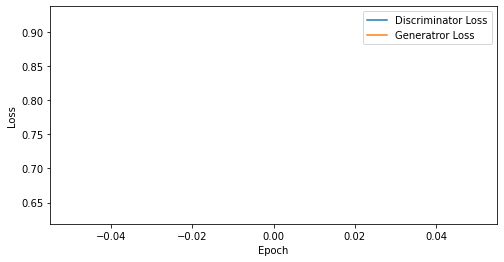

epoch: 1, Discriminator Loss: 0.633266270160675, Generator Loss: 0.9234071969985962


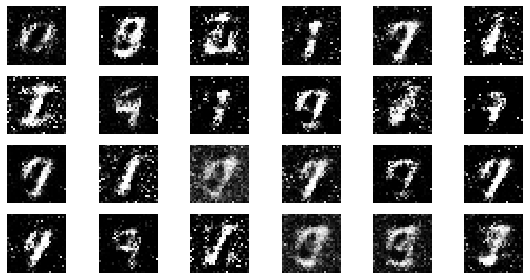

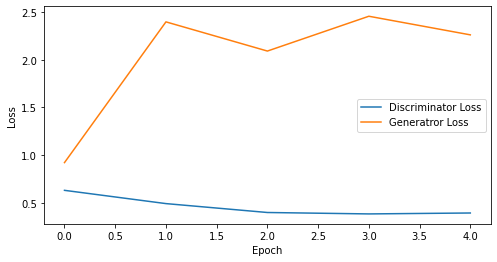

epoch: 5, Discriminator Loss: 0.4623579502105713, Generator Loss: 2.024883008003235


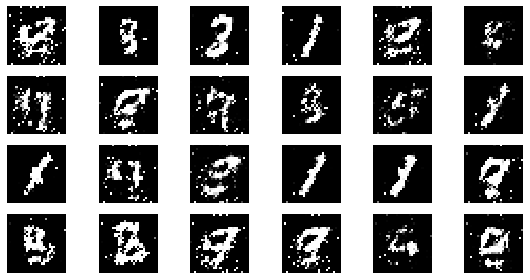

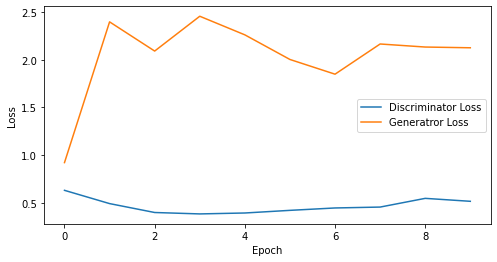

epoch: 10, Discriminator Loss: 0.47103695273399354, Generator Loss: 2.0397031188011168


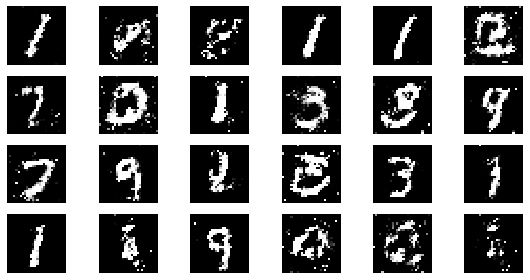

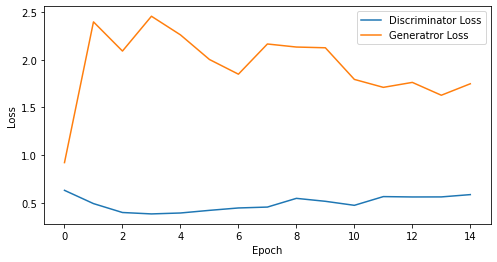

epoch: 15, Discriminator Loss: 0.4980922977129618, Generator Loss: 1.9360515356063843


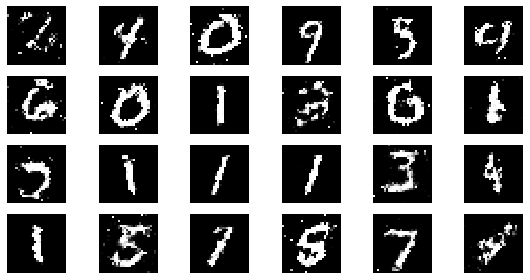

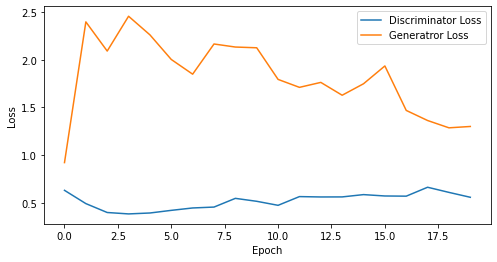

epoch: 20, Discriminator Loss: 0.522785222530365, Generator Loss: 1.8198709189891815


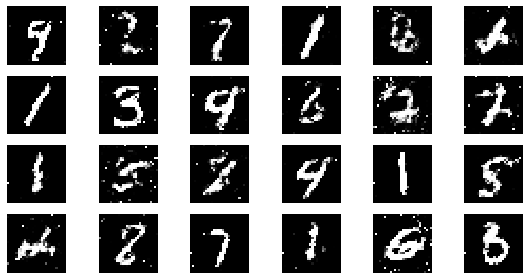

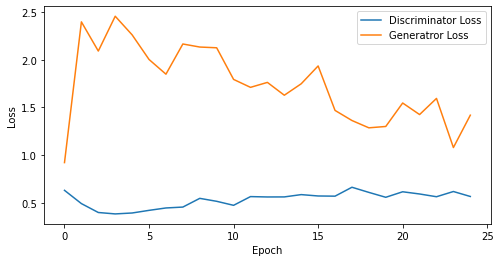

epoch: 25, Discriminator Loss: 0.5370096588134765, Generator Loss: 1.7386406660079956


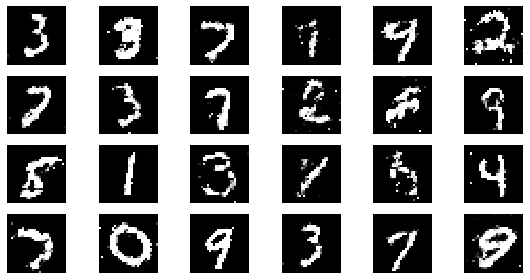

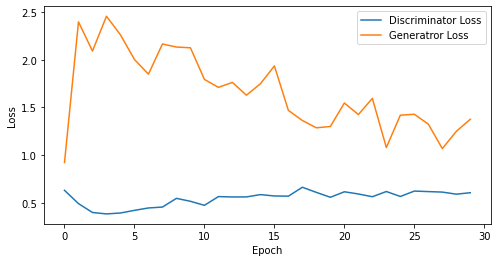

epoch: 30, Discriminator Loss: 0.5495719929536184, Generator Loss: 1.6639544288317363


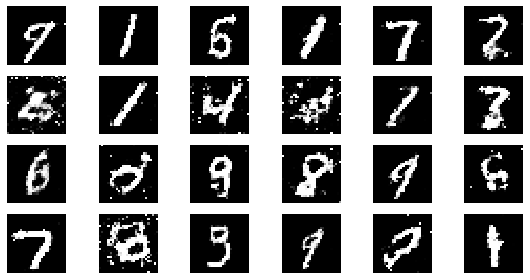

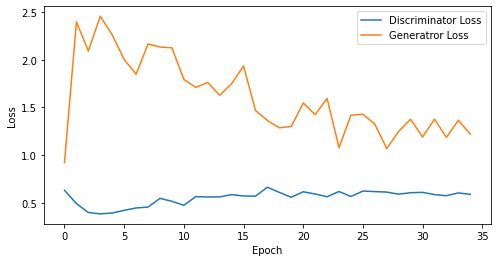

epoch: 35, Discriminator Loss: 0.5560682364872523, Generator Loss: 1.6074701070785522


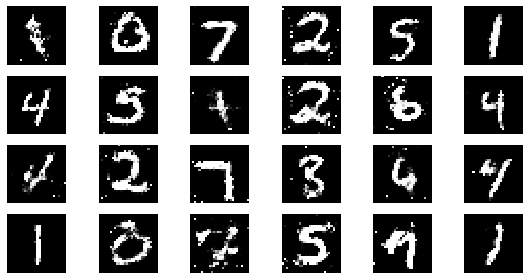

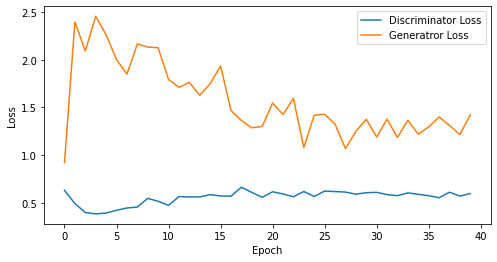

epoch: 40, Discriminator Loss: 0.5595482900738716, Generator Loss: 1.5727895379066468


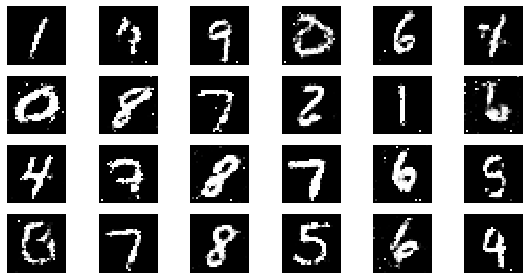

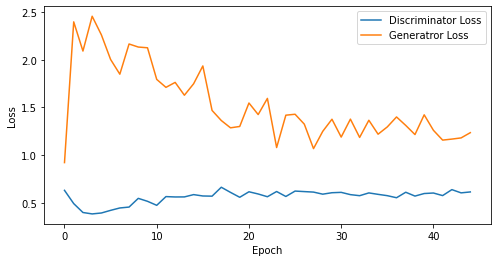

epoch: 45, Discriminator Loss: 0.565097615453932, Generator Loss: 1.5315452761120267


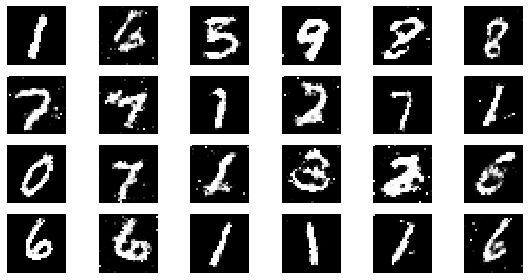

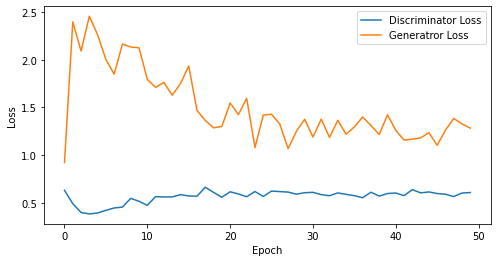

epoch: 50, Discriminator Loss: 0.5681036436557769, Generator Loss: 1.5056853199005127


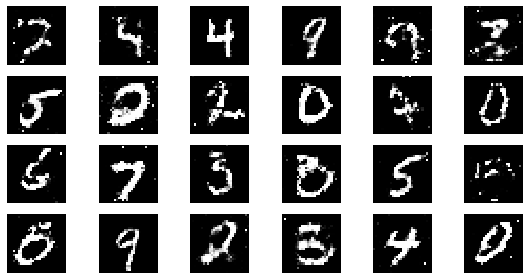

In [24]:
# discriminator와 gan 모델의 loss 측정을 위한 list
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_images in get_batches(x_train, BATCH_SIZE):
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_images = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)